In [30]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

try:
  from tiingo import TiingoClient
except:
  !pip install tiingo
  from tiingo import TiingoClient

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-pastel')

In [31]:
# import data

data = pd.read_csv('AMZN.csv')

data

,Unnamed: 0,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,2012-08-01 00:00:00+00:00,232.09,234.380,230.7001,234.14,2543800,11.6045,11.71900,11.535005,11.7070,50876000,0.0,1.0
1,1,2012-08-02 00:00:00+00:00,230.81,234.340,228.6600,230.56,3048100,11.5405,11.71700,11.433000,11.5280,60962000,0.0,1.0
2,2,2012-08-03 00:00:00+00:00,234.97,236.490,233.0300,234.03,2825300,11.7485,11.82450,11.651500,11.7015,56506000,0.0,1.0
3,3,2012-08-06 00:00:00+00:00,233.99,235.740,233.8100,235.56,1843700,11.6995,11.78700,11.690500,11.7780,36874000,0.0,1.0
4,4,2012-08-07 00:00:00+00:00,236.56,238.000,233.2500,234.13,2058300,11.8280,11.90000,11.662500,11.7065,41166000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2372,2372,2022-01-04 00:00:00+00:00,3350.44,3428.000,3326.9900,3408.76,3536258,167.5220,171.40000,166.349500,170.4380,70725160,0.0,1.0
2373,2373,2022-01-05 00:00:00+00:00,3287.14,3342.525,3287.1400,3337.66,3215136,164.3570,167.12625,164.357000,166.8830,64302720,0.0,1.0
2374,2374,2022-01-06 00:00:00+00:00,3265.08,3296.000,3238.7442,3269.01,2597889,163.2540,164.80000,161.937210,163.4505,51957780,0.0,1.0
2375,2375,2022-01-07 00:00:00+00:00,3251.08,3304.865,3240.6200,3276.78,2330295,162.5540,165.24325,162.031000,163.8390,46605900,0.0,1.0


In [32]:
data = pd.read_csv('AMZN.csv')
data = data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low',
                                'Close':'close', 'Adj Close':'adj_close', 'Adj High': 'adjHigh',
                                'Adj Low': 'adjLow', 'Adj Open': 'adjOpen',
                                'Div Cash': 'divCash', 'Split Factor': 'splitFactor',
                                'Adj Volume':'adjVolume'})
data.head()

,Unnamed: 0,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,2012-08-01 00:00:00+00:00,232.09,234.38,230.7001,234.14,2543800,11.6045,11.7190,11.535005,11.7070,50876000,0.0,1.0
1,1,2012-08-02 00:00:00+00:00,230.81,234.34,228.6600,230.56,3048100,11.5405,11.7170,11.433000,11.5280,60962000,0.0,1.0
2,2,2012-08-03 00:00:00+00:00,234.97,236.49,233.0300,234.03,2825300,11.7485,11.8245,11.651500,11.7015,56506000,0.0,1.0
3,3,2012-08-06 00:00:00+00:00,233.99,235.74,233.8100,235.56,1843700,11.6995,11.7870,11.690500,11.7780,36874000,0.0,1.0
4,4,2012-08-07 00:00:00+00:00,236.56,238.00,233.2500,234.13,2058300,11.8280,11.9000,11.662500,11.7065,41166000,0.0,1.0


In [33]:
data.drop(columns=data.columns[0], axis=1, inplace=True)

In [34]:
data.head(5)

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2012-08-01 00:00:00+00:00,232.09,234.38,230.7001,234.14,2543800,11.6045,11.7190,11.535005,11.7070,50876000,0.0,1.0
1,2012-08-02 00:00:00+00:00,230.81,234.34,228.6600,230.56,3048100,11.5405,11.7170,11.433000,11.5280,60962000,0.0,1.0
2,2012-08-03 00:00:00+00:00,234.97,236.49,233.0300,234.03,2825300,11.7485,11.8245,11.651500,11.7015,56506000,0.0,1.0
3,2012-08-06 00:00:00+00:00,233.99,235.74,233.8100,235.56,1843700,11.6995,11.7870,11.690500,11.7780,36874000,0.0,1.0
4,2012-08-07 00:00:00+00:00,236.56,238.00,233.2500,234.13,2058300,11.8280,11.9000,11.662500,11.7065,41166000,0.0,1.0


In [35]:
print("Total number of days: ", data.shape[0])
print("Total number of fields: ",data.shape[1])

Total number of days:  2377
Total number of fields:  13


In [36]:
# checking for null and N/A values

print("Null values:", data.isnull().values.sum())
print("NA values:", data.isna().values.any())

Null values: 0
NA values: False


In [37]:
# convert date field from string to Date format
data.loc[:, 'date'] = pd.to_datetime(data['date'])

In [66]:
closedf = data[['date','close']]
close_stock = closedf.copy()
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2377, 2)


In [67]:
fig = px.line(closedf, 
              x=closedf.date, 
              y=closedf.close,
              labels={'date':'Date', 
                      'close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', 
                  plot_bgcolor='white', 
                  font_size=15, 
                  font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [68]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(2377, 1)


In [42]:
training_size = int(len(closedf)*0.85) # choosing to use 85% data as training set
test_size = len(closedf) - training_size
train_data, test_data = closedf[0:training_size,:], closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2020, 1)
test_data:  (357, 1)


In [43]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [44]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2004, 15)
y_train:  (2004,)
X_test:  (341, 15)
y_test (341,)


In [45]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2004, 15, 1)
X_test:  (341, 15, 1)


In [46]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(24, activation = 'relu', return_sequences=True,input_shape=(time_step,1)))
model.add(Dropout(0.05))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(Dropout(0.10))
model.add(LSTM(64, activation = 'relu'))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\arkos\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 24)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 32)         │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,689 (135.50 KB)

 Trainable params: 34,689 (135.50 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0614 - val_loss: 0.1240
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0082 - val_loss: 0.0161
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027 - val_loss: 0.0245
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - val_loss: 0.0112
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - val_loss: 0.0081
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

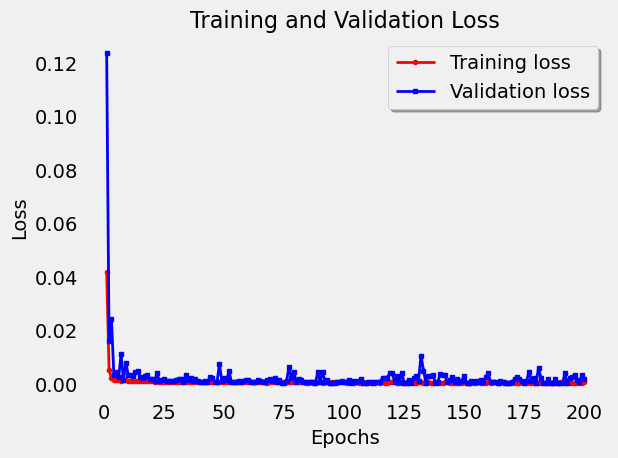

In [53]:
# Assuming 'loss' and 'val_loss' are loaded into these lists
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Use one of the styles available in matplotlib
plt.style.use('fast')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plotting the training and validation loss
ax.plot(epochs, loss, 'r', label='Training loss', linewidth=2, marker='o', markersize=3)
ax.plot(epochs, val_loss, 'b', label='Validation loss', linewidth=2, marker='s', markersize=3)

# Adding title and labels
ax.set_title('Training and Validation Loss', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)

# Adding legend
legend = ax.legend(loc='best', shadow=True)

# Adding grid
ax.grid(False)

# Using tight layout
plt.tight_layout()

# Show plot
plt.show()

In [54]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


((2004, 1), (341, 1))

In [55]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [56]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  47.94048617002999
Train data MSE:  2298.290214218837
Train data MAE:  29.79712271104763
-------------------------------------------------------------------------------------
Test data RMSE:  161.84513955125794
Test data MSE:  26193.84919636616
Test data MAE:  144.22326094551866


In [57]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9956313094838839
Test data explained variance regression score: 0.7629041092702107


In [63]:
close_stock = closedf.copy()

In [70]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                       'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                       'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,
              x=plotdf['date'], 
              y=[plotdf['original_close'],
                 plotdf['train_predicted_close'],
                 plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', 
                  font_size=15, 
                  font_color='black', 
                  legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2377, 1)
Test predicted data:  (2377, 1)


c:\Users\arkos\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [75]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [76]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [77]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,
              x=new_pred_plot.index, 
              y=[new_pred_plot['last_original_days_value'],
                 new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', 
                  font_size=15, 
                  font_color='black',
                  legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [78]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()